Random examples: [9707, 4499, 1567, 2200]


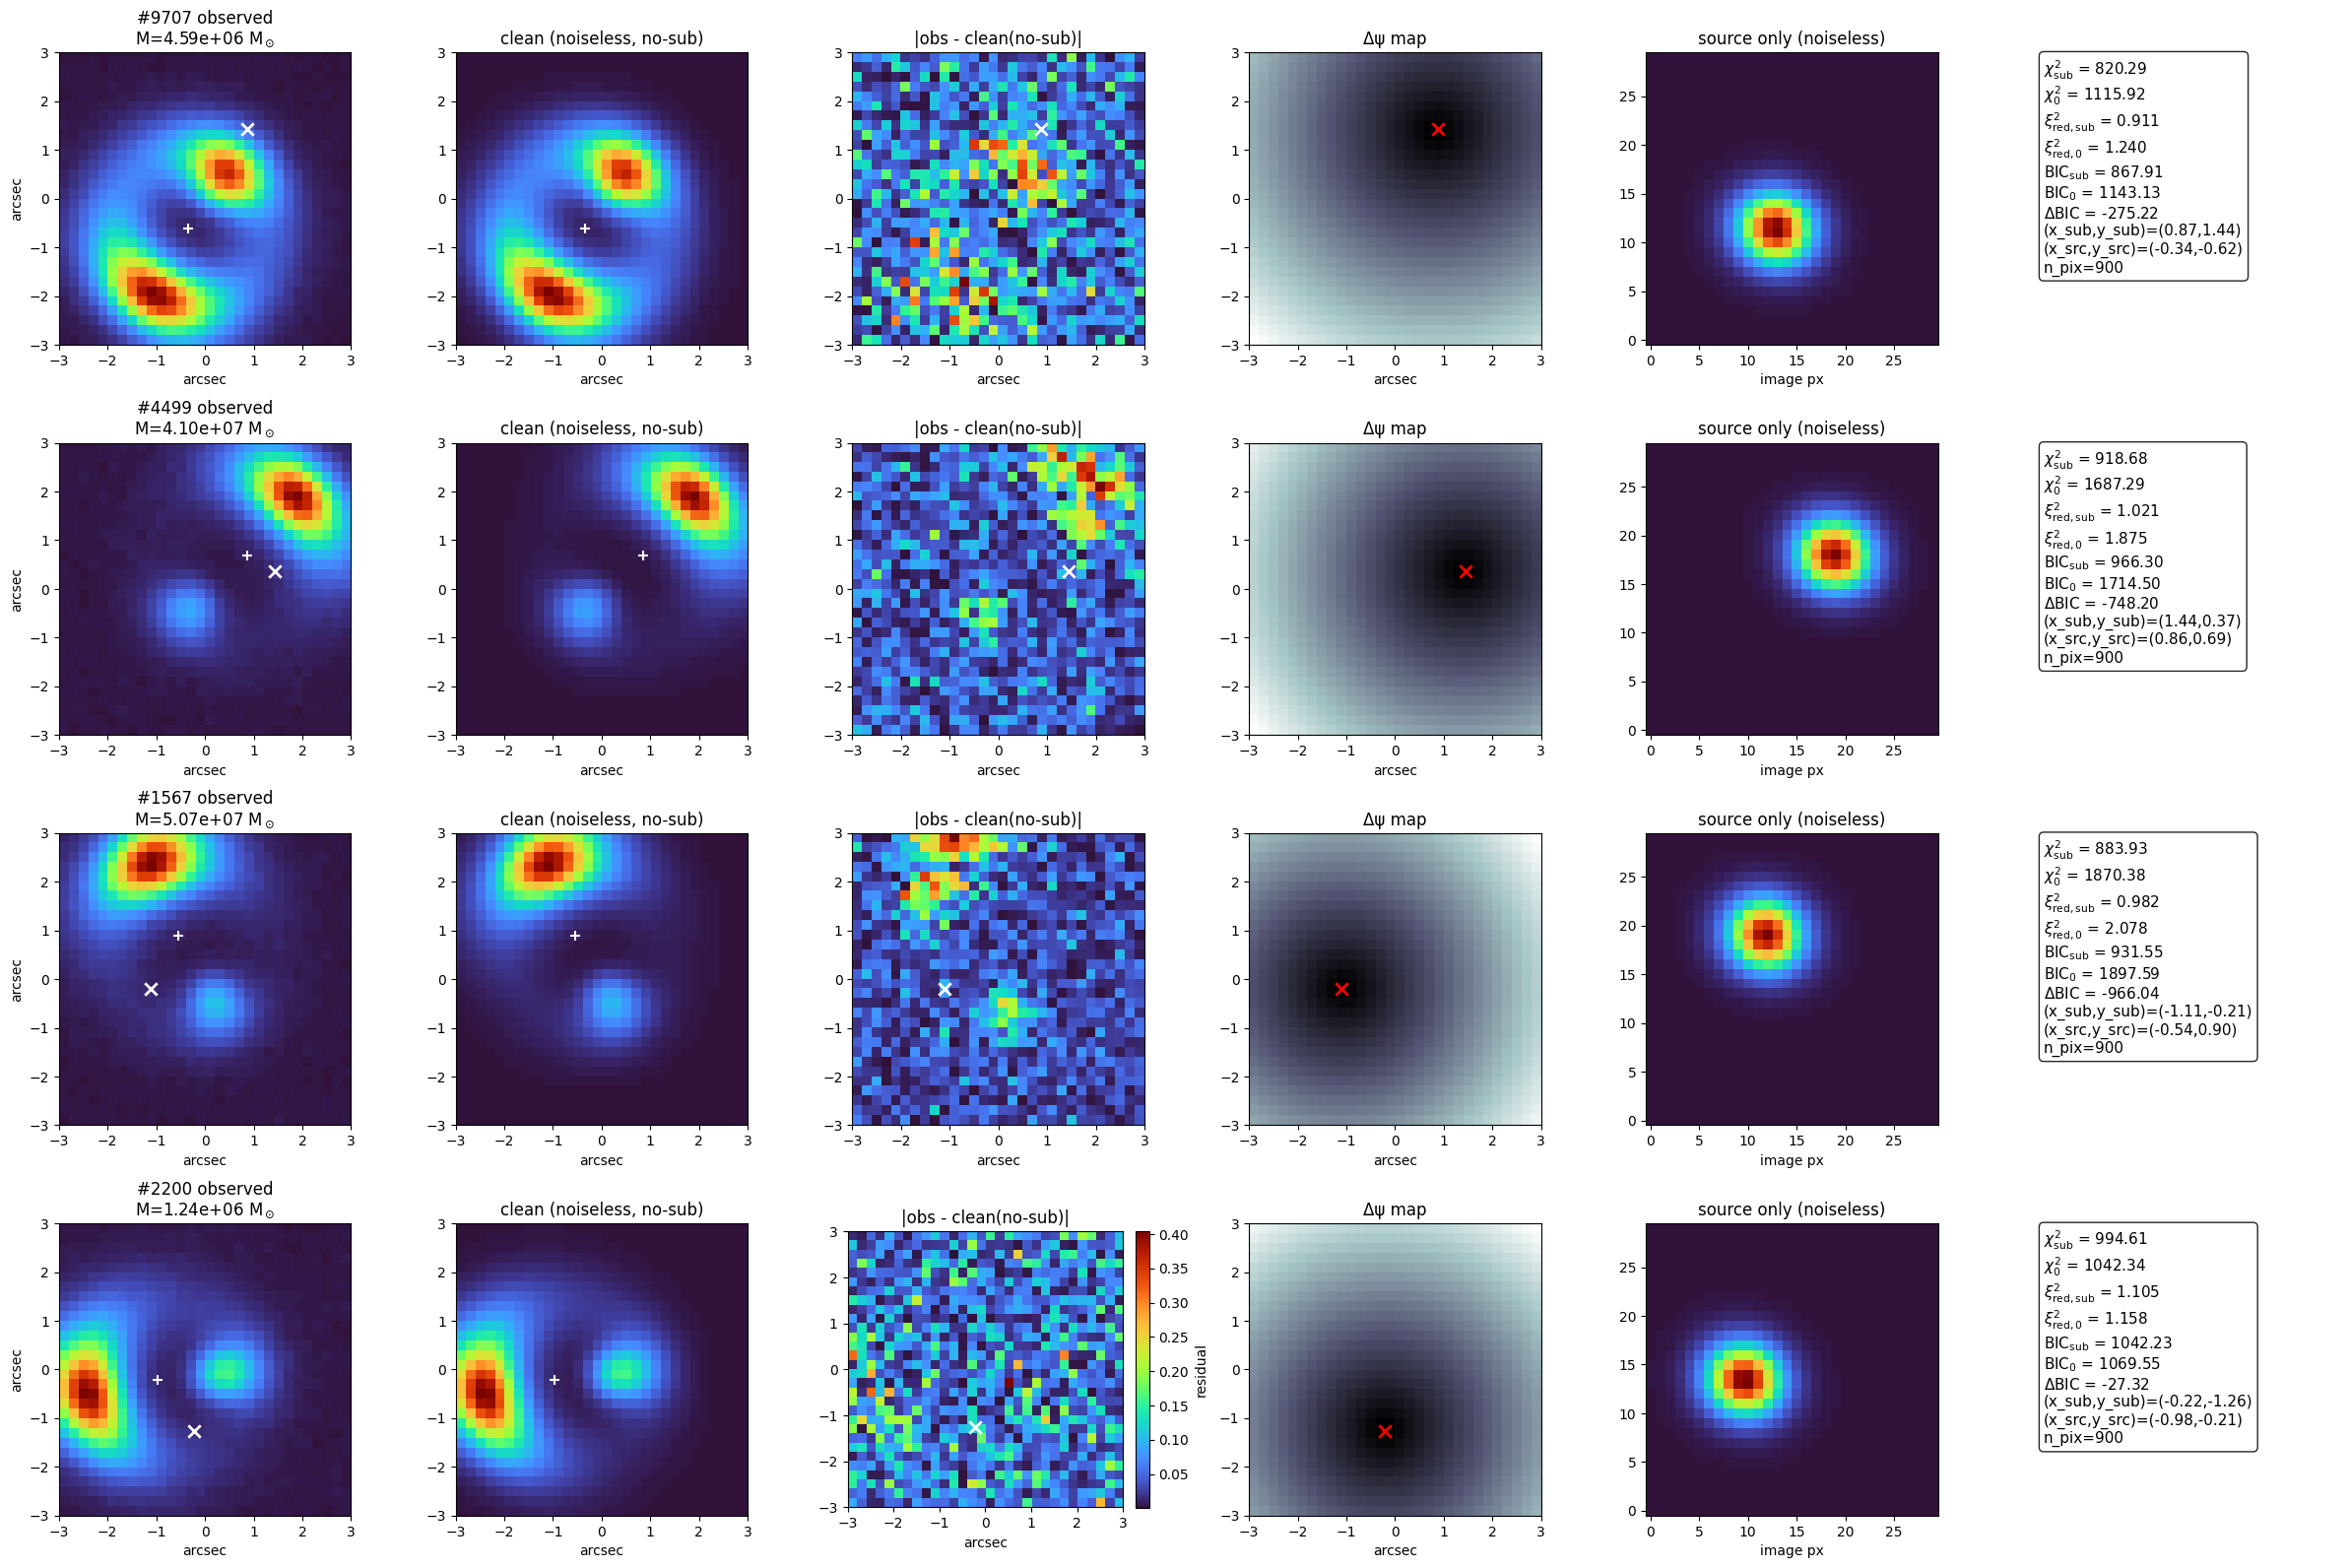

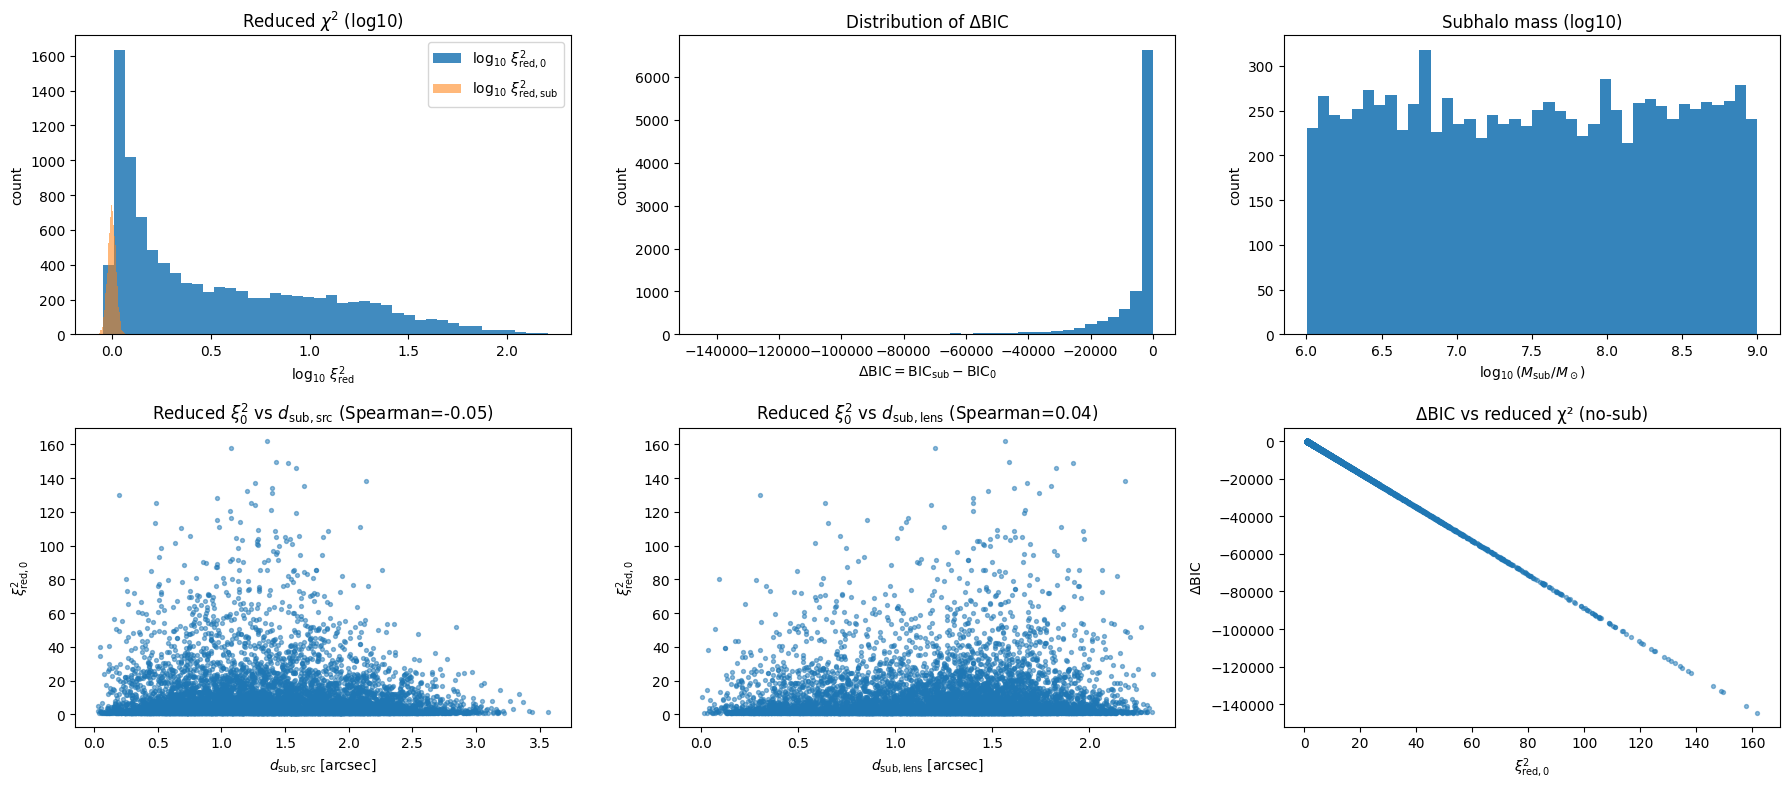

N=10000
reduced χ² (no-sub): median=2.260, p16=1.126, p84=14.320
ΔBIC: median=-1115.822, p16=-11988.929, p84=-85.325


In [1]:
# explore_singleband_h5 — random sampler + diagnostics (BIC-aware, names fixed)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ======================
# Parameters
# ======================
h5_path = "LSST_sb_dataset_BIC.h5"
N_EXAMPLES = 4
RANDOM_SEED = None

# -----------------------------
# Helper functions
# -----------------------------
def _pick_attr(attrs, name, default=None, cast=float):
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _extent_from_attrs(f, shape_hw=None):
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    if shape_hw is None:
        return [-3, 3, -3, 3]
    H, W = shape_hw
    ps = _pick_attr(f.attrs, 'pixel_scale', 0.15)
    return [-W*ps/2, W*ps/2, -H*ps/2, H*ps/2]

def _safe_log10(x, lo=1e-30, hi=1e300):
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

# -----------------------------
# Visualization
# -----------------------------
with h5py.File(h5_path, 'r') as f:
    # Imágenes
    X_obs   = f['image_sub']              # (N,H,W) observada (ruidosa) en mundo SUB
    X_nosub = f['image_nosub_nonoise']    # (N,H,W) modelo NO-SUB sin ruido (baseline)
    X_subnn = f['image_sub_nonoise']      # (N,H,W) modelo SUB sin ruido (opcional para mirar)
    Dpsi    = f['delta_psi']              # (N,H,W)
    Src_nn  = f['source_only_nonoise']    # (N,H,W)
    Src_ny  = f['source_only_noisy']      # (N,H,W)

    # Escalares
    chi2_sub    = f['chi2_sub'][:]        # χ² vs modelo SUB
    chi2r_sub   = f['chi2r_sub'][:]
    chi2_nosub  = f['chi2_nosub'][:]      # χ² vs modelo NO-SUB
    chi2r_nosub = f['chi2r_nosub'][:]
    BIC_sub     = f['BIC_sub'][:]
    BIC_nosub   = f['BIC_nosub'][:]
    dBIC        = f['dBIC'][:]
    n_pix       = f['n_pix'][:]

    # Física / geometría
    mass  = f['subhalo_mass'][:]
    x_sub = f['subhalo_x'][:]
    y_sub = f['subhalo_y'][:]
    x_src = f['source_x'][:]
    y_src = f['source_y'][:]

    # Forma y extent
    N, H, W = X_obs.shape
    extent = _extent_from_attrs(f, (H, W))

    # Ejemplos aleatorios
    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    idxs = rng.choice(np.arange(N), size=min(N_EXAMPLES, N), replace=False)
    print("Random examples:", idxs.tolist())

    # Fig: observed | no-sub clean | residual | Δψ | source-only | metrics
    ncols = 6
    fig, axes = plt.subplots(len(idxs), ncols, figsize=(4*ncols, 4*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        m  = mass[idx]
        xs = x_sub[idx]; ys = y_sub[idx]
        x0 = x_src[idx]; y0 = y_src[idx]

        # (1) Observed (noisy)
        ax = axes[row, 0]
        obs = X_obs[idx]
        ax.imshow(obs, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='w')
        ax.scatter([x0],[y0], s=60, marker='+', lw=1.5, c='w')
        ax.set_title(f"#{idx} observed\nM={m:.2e} M$_\\odot$")
        ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # (2) Clean (noiseless baseline, no-sub)
        ax = axes[row, 1]
        clean0 = X_nosub[idx]
        ax.imshow(clean0, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        ax.scatter([x0],[y0], s=60, marker='+', lw=1.5, c='w')
        ax.set_title("clean (noiseless, no-sub)")
        ax.set_xlabel("arcsec")

        # (3) Residual |obs - clean(no-sub)|
        ax = axes[row, 2]
        resid0 = np.abs(obs - clean0)
        im = ax.imshow(resid0, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='w')
        ax.set_title(r"|obs - clean(no-sub)|")
        ax.set_xlabel("arcsec")
        if row == len(idxs)-1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("residual")

        # (4) Δψ
        ax = axes[row, 3]
        ax.imshow(Dpsi[idx], origin='lower', extent=extent, cmap='bone', interpolation='nearest')
        ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='r')
        ax.set_title("Δψ map")
        ax.set_xlabel("arcsec")

        # (5) Source-only (noiseless)
        ax = axes[row, 4]
        ax.imshow(Src_nn[idx], origin='lower', cmap='turbo', interpolation='nearest')
        ax.set_title("source only (noiseless)")
        ax.set_xlabel("image px")

        # (6) Metrics
        ax = axes[row, 5]; ax.axis('off')
        lines = [
            r"$\chi^2_{\rm sub}$ = %.2f"   % chi2_sub[idx],
            r"$\chi^2_{0}$ = %.2f"         % chi2_nosub[idx],
            r"$\xi^2_{\rm red,sub}$ = %.3f"   % chi2r_sub[idx],
            r"$\xi^2_{\rm red,0}$ = %.3f"     % chi2r_nosub[idx],
            r"${\rm BIC}_{\rm sub}$ = %.2f" % BIC_sub[idx],
            r"${\rm BIC}_{0}$ = %.2f"       % BIC_nosub[idx],
            r"$\Delta{\rm BIC}$ = %.2f"     % dBIC[idx],
            f"(x_sub,y_sub)=({xs:.2f},{ys:.2f})",
            f"(x_src,y_src)=({x0:.2f},{y0:.2f})",
            f"n_pix={int(n_pix[idx])}"
        ]
        ax.text(0.02, 0.98, "\n".join(lines), transform=ax.transAxes,
                va='top', ha='left', fontsize=11,
                bbox=dict(boxstyle='round', fc='white', alpha=.85))

    plt.tight_layout(); plt.show()

    # ===========================================
    # 2) DIAGNÓSTICOS (subplots)
    # ===========================================
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    ax11, ax12, ax13 = axs[0]
    ax21, ax22, ax23 = axs[1]

    # (1,1) Dist. de log10 χ²_red (no-sub) y (sub)
    ax11.hist(_safe_log10(chi2r_nosub), bins=40, alpha=.85, label=r'$\log_{10}\,\xi^2_{\rm red,0}$')
    ax11.hist(_safe_log10(chi2r_sub),   bins=40, alpha=.55, label=r'$\log_{10}\,\xi^2_{\rm red,sub}$')
    ax11.set_xlabel(r'$\log_{10}\,\xi^2_{\rm red}$'); ax11.set_ylabel("count")
    ax11.set_title("Reduced $\\chi^2$ (log10)"); ax11.legend()

    # (1,2) ΔBIC
    ax12.hist(dBIC[np.isfinite(dBIC)], bins=40, alpha=.9)
    ax12.set_xlabel(r'$\Delta{\rm BIC} = {\rm BIC}_{\rm sub} - {\rm BIC}_{0}$')
    ax12.set_ylabel("count"); ax12.set_title("Distribution of ΔBIC")

    # (1,3) Masa (log10)
    logM = _safe_log10(mass)
    ax13.hist(logM[np.isfinite(logM)], bins=40, alpha=.9)
    ax13.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$'); ax13.set_ylabel("count")
    ax13.set_title("Subhalo mass (log10)")

    # Geometría
    d_sub_src  = np.hypot(x_sub - x_src, y_sub - y_src)
    d_sub_lens = np.hypot(x_sub - _pick_attr(f.attrs, "lens_center_x", 0.0),
                          y_sub - _pick_attr(f.attrs, "lens_center_y", -0.1))
    d_src_lens = np.hypot(x_src - _pick_attr(f.attrs, "lens_center_x", 0.0),
                          y_src - _pick_attr(f.attrs, "lens_center_y", -0.1))

    # (2,1) χ²_red(no-sub) vs d(sub,src)
    rho, _ = spearmanr(d_sub_src, chi2r_nosub, nan_policy="omit")
    ax21.scatter(d_sub_src, chi2r_nosub, s=8, alpha=.5)
    ax21.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
    ax21.set_ylabel(r'$\xi^2_{\rm red,0}$')
    ax21.set_title(f'Reduced $\\xi^2_0$ vs $d_{{\\rm sub,src}}$ (Spearman={rho:.2f})')

    # (2,2) χ²_red(no-sub) vs d(sub,lens)
    rho2, _ = spearmanr(d_sub_lens, chi2r_nosub, nan_policy="omit")
    ax22.scatter(d_sub_lens, chi2r_nosub, s=8, alpha=.5)
    ax22.set_xlabel(r'$d_{\rm sub,lens}$ [arcsec]')
    ax22.set_ylabel(r'$\xi^2_{\rm red,0}$')
    ax22.set_title(f'Reduced $\\xi^2_0$ vs $d_{{\\rm sub,lens}}$ (Spearman={rho2:.2f})')

    # (2,3) ΔBIC vs χ²_red(no-sub)
    msk = np.isfinite(dBIC) & np.isfinite(chi2r_nosub)
    ax23.scatter(chi2r_nosub[msk], dBIC[msk], s=8, alpha=.5)
    ax23.set_xlabel(r'$\xi^2_{\rm red,0}$')
    ax23.set_ylabel(r'$\Delta{\rm BIC}$')
    ax23.set_title("ΔBIC vs reduced χ² (no-sub)")

    plt.tight_layout(); plt.show()

    # Resumen rápido
    print(f"N={N}")
    print("reduced χ² (no-sub): median=%.3f, p16=%.3f, p84=%.3f" %
          (np.nanmedian(chi2r_nosub), np.nanpercentile(chi2r_nosub, 16), np.nanpercentile(chi2r_nosub, 84)))
    print("ΔBIC: median=%.3f, p16=%.3f, p84=%.3f" %
          (np.nanmedian(dBIC), np.nanpercentile(dBIC, 16), np.nanpercentile(dBIC, 84)))


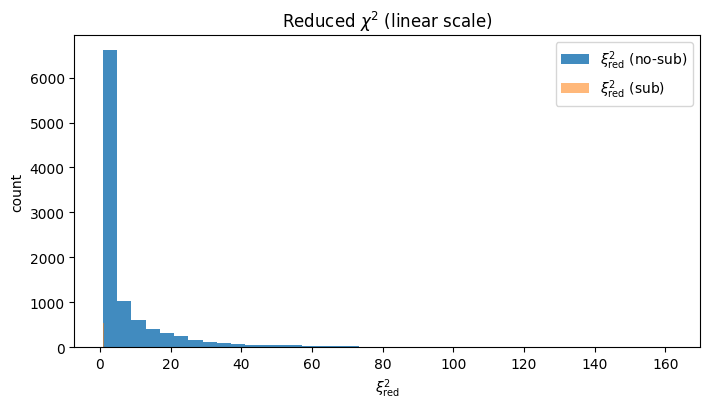

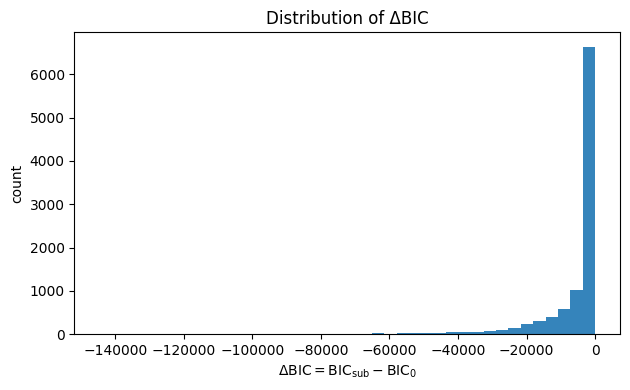

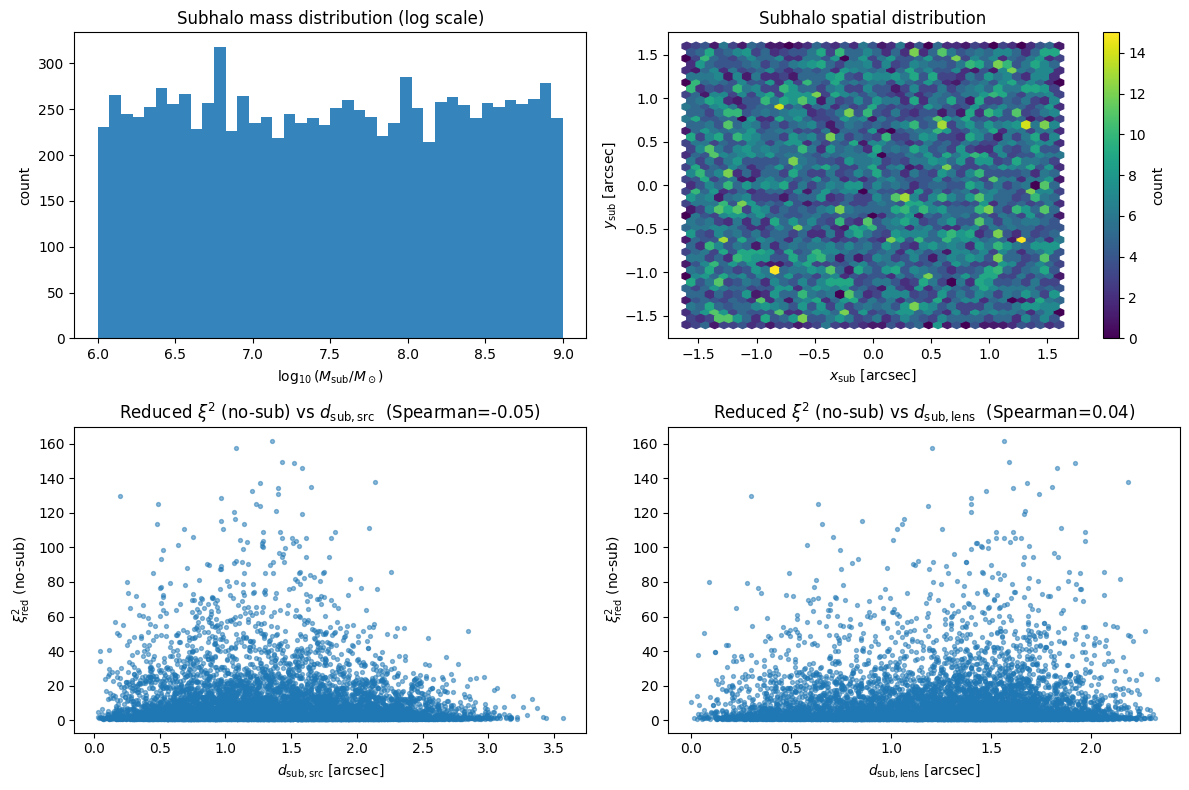

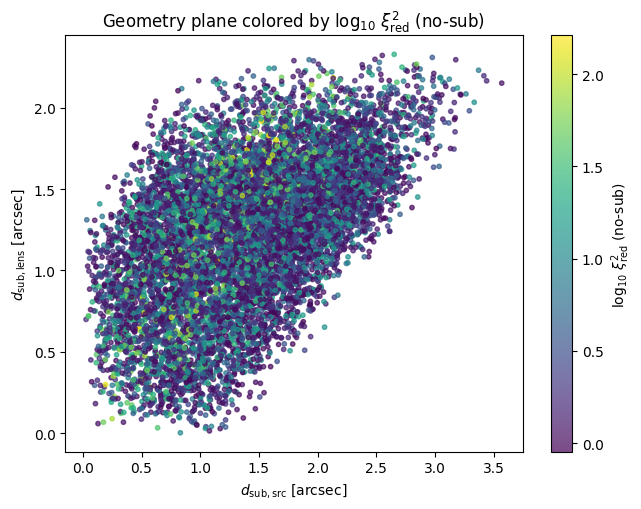

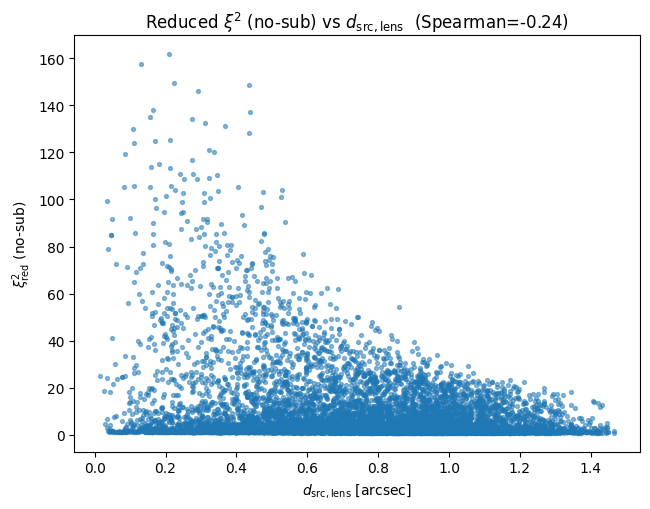

In [2]:
# ==== Cell: Mass/position distributions and geometry vs. reduced χ² ====
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

H5 = "LSST_sb_dataset_BIC.h5"

def _pick_attr(attrs, name, default=None, cast=float):
    """Safe attribute getter with default and optional casting."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _safe_log10(a, lo=1e-30):
    a = np.asarray(a, float)
    return np.log10(np.clip(a, lo, None))

# ---------- Load scalars ----------
with h5py.File(H5, "r") as f:
    # Physics / geometry
    M   = f["subhalo_mass"][:]         # (N,) Msun
    xs  = f["subhalo_x"][:]            # (N,) arcsec
    ys  = f["subhalo_y"][:]            # (N,) arcsec
    x0  = f["source_x"][:]             # (N,) arcsec
    y0  = f["source_y"][:]             # (N,) arcsec

    # Reduced chi-squares (new scheme: computed vs image_obs for each hypothesis)
    chi2r_nosub = f["chi2r_nosub"][:]  # (N,) reduced χ² under "no-sub" model
    chi2r_sub   = f["chi2r_sub"][:]    # (N,) reduced χ² under "sub" model

    # Optional: ΔBIC if present
    dBIC = f["dBIC"][:] if "dBIC" in f else None

    # Lens center from attributes (fallback to the values used in generator)
    cx = _pick_attr(f.attrs, "lens_center_x", 0.0)
    cy = _pick_attr(f.attrs, "lens_center_y", -0.1)

# ---------- Derived geometric quantities ----------
# Distances (in arcsec)
d_sub_src  = np.hypot(xs - x0, ys - y0)   # subhalo–source
d_sub_lens = np.hypot(xs - cx, ys - cy)   # subhalo–lens center
d_src_lens = np.hypot(x0 - cx, y0 - cy)   # source–lens center

# Logs for plotting
logM   = _safe_log10(M)
logXi0 = _safe_log10(chi2r_nosub)   # main signal proxy
logXi1 = _safe_log10(chi2r_sub)     # optional for comparison

# ---------- Figure 0: Reduced χ² histograms (linear scale) ----------
plt.figure(figsize=(7.2, 4.2))
vals0 = chi2r_nosub[np.isfinite(chi2r_nosub)]
plt.hist(vals0, bins=40, alpha=0.85, label=r'$\xi^2_{\rm red}$ (no-sub)')
# opcional: sobreponer el del modelo con subhalo
vals1 = chi2r_sub[np.isfinite(chi2r_sub)]
plt.hist(vals1, bins=40, alpha=0.55, label=r'$\xi^2_{\rm red}$ (sub)')
plt.xlabel(r'$\xi^2_{\rm red}$')
plt.ylabel('count')
plt.title('Reduced $\\chi^2$ (linear scale)')
plt.legend()
plt.tight_layout()
plt.show()

# (opcional) ΔBIC histogram if available
if dBIC is not None:
    plt.figure(figsize=(6.4, 4))
    db = dBIC[np.isfinite(dBIC)]
    plt.hist(db, bins=40, alpha=0.9)
    plt.xlabel(r'$\Delta\mathrm{BIC} = \mathrm{BIC}_{\rm sub} - \mathrm{BIC}_{0}$')
    plt.ylabel('count')
    plt.title('Distribution of ΔBIC')
    plt.tight_layout()
    plt.show()

# ---------- Figure 1: Mass and position distributions ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax11, ax12 = axs[0]
ax21, ax22 = axs[1]

# (1,1) Histogram of log10 subhalo mass
ax11.hist(logM, bins=40, alpha=.9)
ax11.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
ax11.set_ylabel('count')
ax11.set_title('Subhalo mass distribution (log scale)')

# (1,2) 2D hexbin of subhalo positions
hb = ax12.hexbin(xs, ys, gridsize=40, cmap='viridis')
ax12.set_xlabel(r'$x_{\rm sub}$ [arcsec]')
ax12.set_ylabel(r'$y_{\rm sub}$ [arcsec]')
ax12.set_title('Subhalo spatial distribution')
cb = plt.colorbar(hb, ax=ax12); cb.set_label('count')

# (2,1) Reduced χ²(no-sub) vs distance subhalo–source
rho, _ = spearmanr(d_sub_src, chi2r_nosub, nan_policy="omit")
ax21.scatter(d_sub_src, chi2r_nosub, s=8, alpha=.5)
ax21.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax21.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax21.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm sub,src}}$  (Spearman={rho:.2f})')

# (2,2) Reduced χ²(no-sub) vs distance subhalo–lens center
rho2, _ = spearmanr(d_sub_lens, chi2r_nosub, nan_policy="omit")
ax22.scatter(d_sub_lens, chi2r_nosub, s=8, alpha=.5)
ax22.set_xlabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax22.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax22.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm sub,lens}}$  (Spearman={rho2:.2f})')

plt.tight_layout()
plt.show()

# ---------- Figure 2: Geometry plane colored by log10 reduced χ²(no-sub) ----------
fig, ax = plt.subplots(figsize=(6.6, 5.2))
sc = ax.scatter(d_sub_src, d_sub_lens, c=logXi0, s=10, alpha=.7)
ax.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax.set_ylabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax.set_title(r'Geometry plane colored by $\log_{10}\,\xi^2_{\rm red}$ (no-sub)')
cb = plt.colorbar(sc, ax=ax); cb.set_label(r'$\log_{10}\,\xi^2_{\rm red}$ (no-sub)')
plt.tight_layout()
plt.show()

# ---------- Figure 3: Reduced χ²(no-sub) vs source–lens distance ----------
fig, ax = plt.subplots(figsize=(6.6, 5.2))
rho3, _ = spearmanr(d_src_lens, chi2r_nosub, nan_policy="omit")
ax.scatter(d_src_lens, chi2r_nosub, s=8, alpha=.5)
ax.set_xlabel(r'$d_{\rm src,lens}$ [arcsec]')
ax.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm src,lens}}$  (Spearman={rho3:.2f})')
plt.tight_layout()
plt.show()


In [ ]:
# ==== Cell: Mass/position distributions + BIC vs mass + geometry vs reduced χ² ====
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

H5 = "LSST_sb_dataset_BIC.h5"

def _pick_attr(attrs, name, default=None, cast=float):
    """Safe attribute getter with default and optional casting."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _safe_log10(a, lo=1e-30):
    a = np.asarray(a, float)
    return np.log10(np.clip(a, lo, None))

# ---------- Load scalars ----------
with h5py.File(H5, "r") as f:
    # Physics / geometry
    M   = f["subhalo_mass"][:]          # (N,) Msun
    xs  = f["subhalo_x"][:]             # (N,) arcsec
    ys  = f["subhalo_y"][:]             # (N,) arcsec
    x0  = f["source_x"][:]              # (N,) arcsec
    y0  = f["source_y"][:]              # (N,) arcsec

    # Reduced chi-squares (computed vs image_obs for each hypothesis)
    chi2r_nosub = f["chi2r_nosub"][:]   # (N,) reduced χ² under "no-sub" model
    chi2r_sub   = f["chi2r_sub"][:]     # (N,) reduced χ² under "sub" model

    # Information criteria (if present)
    BIC_sub   = f["BIC_sub"][:]   if "BIC_sub"   in f else None
    BIC_nosub = f["BIC_nosub"][:] if "BIC_nosub" in f else None
    dBIC      = f["dBIC"][:]      if "dBIC"      in f else None

    # Lens center from attributes (fallback to generator defaults)
    cx = _pick_attr(f.attrs, "lens_center_x", 0.0)
    cy = _pick_attr(f.attrs, "lens_center_y", -0.1)

# ---------- Derived geometric quantities ----------
d_sub_src  = np.hypot(xs - x0, ys - y0)   # subhalo–source [arcsec]
d_sub_lens = np.hypot(xs - cx, ys - cy)   # subhalo–lens center [arcsec]
d_src_lens = np.hypot(x0 - cx, y0 - cy)   # source–lens center [arcsec]

# Logs for plotting
logM   = _safe_log10(M)
logXi0 = _safe_log10(chi2r_nosub)   # proxy of signal (no-sub model)
logXi1 = _safe_log10(chi2r_sub)     # optional comparison

# ---------- Figure 0: Reduced χ² histograms (linear scale) ----------
plt.figure(figsize=(7.4, 4.4))
vals0 = chi2r_nosub[np.isfinite(chi2r_nosub)]
plt.hist(vals0, bins=40, alpha=0.85, label=r'$\xi^2_{\rm red}$ (no-sub)')
vals1 = chi2r_sub[np.isfinite(chi2r_sub)]
plt.hist(vals1, bins=40, alpha=0.55, label=r'$\xi^2_{\rm red}$ (sub)')
plt.xlabel(r'Reduced $\chi^2$')
plt.ylabel('count')
plt.title('Reduced $\chi^2$ (linear scale)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Figure 0b: BIC / ΔBIC histograms (if available) ----------
if (BIC_sub is not None) and (BIC_nosub is not None):
    plt.figure(figsize=(7.4, 4.4))
    plt.hist(BIC_sub[np.isfinite(BIC_sub)], bins=40, alpha=0.7, label='BIC_sub')
    plt.hist(BIC_nosub[np.isfinite(BIC_nosub)], bins=40, alpha=0.7, label='BIC_nosub')
    plt.xlabel('BIC')
    plt.ylabel('count')
    plt.title('BIC distributions')
    plt.legend()
    plt.tight_layout()
    plt.show()

if dBIC is not None:
    plt.figure(figsize=(6.4, 4.2))
    db = dBIC[np.isfinite(dBIC)]
    plt.hist(db, bins=40, alpha=0.9)
    plt.xlabel(r'$\Delta{\rm BIC} = {\rm BIC}_{\rm sub} - {\rm BIC}_{0}$')
    plt.ylabel('count')
    plt.title('Distribution of ΔBIC (negative favors subhalo)')
    plt.tight_layout()
    plt.show()

# ---------- Figure 1: Mass and position distributions ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax11, ax12 = axs[0]
ax21, ax22 = axs[1]

# (1,1) Histogram of log10 subhalo mass
ax11.hist(logM, bins=40, alpha=.9)
ax11.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
ax11.set_ylabel('count')
ax11.set_title('Subhalo mass distribution (log scale)')

# (1,2) 2D hexbin of subhalo positions
hb = ax12.hexbin(xs, ys, gridsize=40, cmap='viridis')
ax12.set_xlabel(r'$x_{\rm sub}$ [arcsec]')
ax12.set_ylabel(r'$y_{\rm sub}$ [arcsec]')
ax12.set_title('Subhalo spatial distribution')
cb = plt.colorbar(hb, ax=ax12); cb.set_label('count')

# (2,1) Reduced χ²(no-sub) vs distance subhalo–source
rho, _ = spearmanr(d_sub_src, chi2r_nosub, nan_policy="omit")
ax21.scatter(d_sub_src, chi2r_nosub, s=8, alpha=.5)
ax21.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax21.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax21.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm sub,src}}$  (Spearman={rho:.2f})')

# (2,2) Reduced χ²(no-sub) vs distance subhalo–lens center
rho2, _ = spearmanr(d_sub_lens, chi2r_nosub, nan_policy="omit")
ax22.scatter(d_sub_lens, chi2r_nosub, s=8, alpha=.5)
ax22.set_xlabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax22.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax22.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm sub,lens}}$  (Spearman={rho2:.2f})')

plt.tight_layout()
plt.show()

# ---------- Figure 1b: BIC vs mass (and ΔBIC vs mass) ----------
if (BIC_sub is not None) and (BIC_nosub is not None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.6))

    # BIC_sub and BIC_nosub vs log10(M)
    msk_bic = np.isfinite(logM) & np.isfinite(BIC_sub) & np.isfinite(BIC_nosub)
    ax = axs[0]
    ax.scatter(logM[msk_bic], BIC_sub[msk_bic], s=8, alpha=.5, label='BIC_sub')
    ax.scatter(logM[msk_bic], BIC_nosub[msk_bic], s=8, alpha=.5, label='BIC_nosub')
    r_bic_sub, _   = spearmanr(logM[msk_bic], BIC_sub[msk_bic])   if np.any(msk_bic) else (np.nan, None)
    r_bic_nosub, _ = spearmanr(logM[msk_bic], BIC_nosub[msk_bic]) if np.any(msk_bic) else (np.nan, None)
    ax.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
    ax.set_ylabel('BIC')
    ax.set_title(f'BIC vs mass (ρ_sub={r_bic_sub:.2f}, ρ_0={r_bic_nosub:.2f})')
    ax.legend()

    # ΔBIC vs log10(M)
    if dBIC is not None:
        msk_db = np.isfinite(logM) & np.isfinite(dBIC)
        ax = axs[1]
        ax.scatter(logM[msk_db], dBIC[msk_db], s=8, alpha=.5)
        r_db, _ = spearmanr(logM[msk_db], dBIC[msk_db]) if np.any(msk_db) else (np.nan, None)
        ax.axhline(0.0, color='r', lw=1)
        ax.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
        ax.set_ylabel(r'$\Delta{\rm BIC}$ (sub − no-sub)')
        ax.set_title(f'ΔBIC vs mass (Spearman={r_db:.2f})')
    else:
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# ---------- Figure 2: Geometry plane colored by log10 reduced χ²(no-sub) ----------
fig, ax = plt.subplots(figsize=(6.8, 5.2))
msk_geo = np.isfinite(d_sub_src) & np.isfinite(d_sub_lens) & np.isfinite(logXi0)
sc = ax.scatter(d_sub_src[msk_geo], d_sub_lens[msk_geo], c=logXi0[msk_geo], s=10, alpha=.7)
ax.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax.set_ylabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax.set_title(r'Geometry plane colored by $\log_{10}\,\xi^2_{\rm red}$ (no-sub)')
cb = plt.colorbar(sc, ax=ax); cb.set_label(r'$\log_{10}\,\xi^2_{\rm red}$ (no-sub)')
plt.tight_layout()
plt.show()

# ---------- Figure 3: Reduced χ²(no-sub) vs source–lens distance ----------
fig, ax = plt.subplots(figsize=(6.8, 5.2))
rho3, _ = spearmanr(d_src_lens, chi2r_nosub, nan_policy="omit")
ax.scatter(d_src_lens, chi2r_nosub, s=8, alpha=.5)
ax.set_xlabel(r'$d_{\rm src,lens}$ [arcsec]')
ax.set_ylabel(r'$\xi^2_{\rm red}$ (no-sub)')
ax.set_title(f'Reduced $\\xi^2$ (no-sub) vs $d_{{\\rm src,lens}}$  (Spearman={rho3:.2f})')
plt.tight_layout()
plt.show()


## 📦 Data Loading (DataLoader) — LSST *single-band* Dataset with BIC

### 🎯 **Purpose**
This cell builds PyTorch `DataLoaders` for the dataset `LSST_sb_dataset_BIC.h5`, ready to train a model that **predicts a statistical quantity** (e.g., $\sqrt{\chi^2_{\rm red}}$, $\Delta{\rm BIC}$, etc.) directly from the **noisy observed image**.

---

### ⚙️ **What it does**
- Opens the HDF5 file and **reads the input images** from `image_obs` (or `image_sub` if not available), converting them into `(1,H,W)` float32 tensors.
- Allows selecting the **target variable** (`target_key`) among:
  - `chi2r_nosub`, `chi2r_sub`
  - `dBIC`  (=$\mathrm{BIC}_{\rm sub}-\mathrm{BIC}_0$)
  - `BIC_sub`, `BIC_nosub`
- Applies a **target transformation** (`y_transform`) for numerical stability:
  - `"identity"` → no transformation  
  - `"log10"` → $\log_{10}(y + 10^{-3})$  
  - `"sqrt"` → $\sqrt{y + 10^{-3}}$  ← *recommended by the advisor for $\chi^2_{\rm red}$*
- Performs a **reproducible 70/15/15 split** (train/val/test).
- Returns:
  - `dl_tr`, `dl_va`, `dl_te`: ready-to-use PyTorch DataLoaders  
  - `meta`: a summary dictionary with dataset size and key names.

---

### 🔑 **Main parameters**
| Parameter | Description | Default value |
|------------|--------------|----------------|
| `h5_path` | Path to the dataset | `"LSST_sb_dataset_BIC.h5"` |
| `target_key` | Statistical target to predict | `"chi2r_nosub"` |
| `y_transform` | Type of target transformation | `"sqrt"` |
| `batch_size` | Batch size | 16 |
| `num_workers` | Parallel loading workers | 2 |
| `seed` | Random seed for reproducibility | 123 |

---

### 📥 **Inputs / Outputs**
- **Input (X):** noisy observed image (`image_obs`) → tensor `(B,1,H,W)`
- **Output (y):** scalar per image (defined by `target_key`) → tensor `(B,1)`
- **Meta:** dictionary containing `N`, split sizes, and dataset keys

---

### 💡 **Tips**
- If `h5py` raises multiprocessing errors, set `num_workers=0`.
- The loader is backward-compatible with earlier datasets (`image_sub`).
- You can train different regressors simply by changing `target_key`:
  - For $\sqrt{\chi^2_{\rm red}}$:  
    ```python
    target_key="chi2r_nosub", y_transform="sqrt"
    ```
  - For $\Delta{\rm BIC}$:  
    ```python
    target_key="dBIC", y_transform="identity"
    ```

---

### 🧠 **Summary**
This cell is the foundation of the training pipeline: it loads, transforms, and prepares LSST simulated lensing data (with or without subhalos), enabling a model to learn to **predict physical or statistical metrics (χ², BIC, ΔBIC)** directly from the images.


In [ ]:
# xi2reduced_dataloader_singleband_min.py (BIC-aware)
# ---------------------------------------------------
# Minimal yet flexible DataLoader for single-band LSST dataset (BIC version)
# Inputs: observed noisy image ("image_obs" fallback "image_sub")
# Targets: choose among {"chi2r_nosub","chi2r_sub","dBIC","BIC_sub","BIC_nosub"}
# Transform: {"identity","log10","sqrt"}

import h5py, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

# === Global config (you can override in build_dataloaders) ===
H5_PATH     = "LSST_sb_dataset_BIC.h5"
BATCH_SIZE  = 16
NUM_WORKERS = 2
SEED        = 123

# Keys (with fallbacks resolved at runtime)
IMG_KEYS_CANDIDATES = ["image_obs", "image_sub"]

# Default target & transform
DEFAULT_TARGET_KEY = "chi2r_nosub"  # alternatives: "chi2r_sub","dBIC","BIC_sub","BIC_nosub"
DEFAULT_Y_TRANSFORM = "log10"       # alternatives: "identity","sqrt"

def _y_transform(y, kind="log10"):
    y = np.asarray(y, dtype="f4")
    if kind == "identity":
        return y
    elif kind == "log10":
        return np.log10(y + 1e-3)  # estable en colas
    elif kind == "sqrt":
        return np.sqrt(y + 1e-3)   # lo que sugirió tu asesor para χ²_red
    else:
        raise ValueError(f"Unknown transform '{kind}'")

# ===========================================================
# Custom Dataset
# ===========================================================
class StatDataset(Dataset):
    def __init__(self, h5_path, indices,
                 target_key=DEFAULT_TARGET_KEY,
                 y_transform=DEFAULT_Y_TRANSFORM):
        """
        Args:
            h5_path (str): path to HDF5 file
            indices (array-like): split indices
            target_key (str): one of {"chi2r_nosub","chi2r_sub","dBIC","BIC_sub","BIC_nosub"}
            y_transform (str): {"identity","log10","sqrt"}
        """
        self.f = h5py.File(h5_path, "r")
        # Resolve image key
        img_key = None
        for k in IMG_KEYS_CANDIDATES:
            if k in self.f:
                img_key = k
                break
        if img_key is None:
            raise KeyError(f"None of {IMG_KEYS_CANDIDATES} found in {h5_path}.")
        self.img_key = img_key
        self.X = self.f[self.img_key]  # (N,H,W) or (N,H,W,1)

        # Resolve target key
        if target_key not in self.f:
            raise KeyError(f"Target key '{target_key}' not found in {h5_path}.")
        self.target_key = target_key
        self.y_raw = self.f[target_key][:].astype("f4")

        self.idxs = np.asarray(indices)
        self.y_transform = y_transform

        # Define how to return images as (1,H,W) float32
        sample = self.X[0]
        if sample.ndim == 2:
            self._get_item = lambda i: self.X[i][None, ...].astype("f4")
        elif sample.ndim == 3:
            def _getter(i):
                arr = self.X[i].astype("f4")
                # (H,W,1) -> (1,H,W); if (H,W,C>1) keep channel-first
                if arr.shape[-1] >= 1:
                    return np.transpose(arr, (2, 0, 1))
                raise ValueError("Unexpected last-dim for image array.")
            self._get_item = _getter
        else:
            raise ValueError(f"Unexpected image shape ndim={sample.ndim}")

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, k):
        i = int(self.idxs[k])
        x = self._get_item(i)                       # (1,H,W) float32
        y = _y_transform(self.y_raw[i], self.y_transform).reshape(1)  # (1,)
        return {"x": torch.from_numpy(x), "y": torch.from_numpy(y), "idx": i}

    def __del__(self):
        try:
            self.f.close()
        except Exception:
            pass

# ===========================================================
# Build DataLoaders (random 70/15/15 split)
# ===========================================================
def build_dataloaders(h5_path=H5_PATH, batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS, seed=SEED,
                      target_key=DEFAULT_TARGET_KEY,
                      y_transform=DEFAULT_Y_TRANSFORM):
    rng = np.random.default_rng(seed)
    with h5py.File(h5_path, "r") as f:
        # pick image key for N
        img_key = None
        for k in IMG_KEYS_CANDIDATES:
            if k in f:
                img_key = k; break
        if img_key is None:
            raise KeyError(f"None of {IMG_KEYS_CANDIDATES} found in {h5_path}.")
        N = f[img_key].shape[0]

    # Split
    idx = np.arange(N); rng.shuffle(idx)
    n_tr = int(0.70 * N); n_va = int(0.15 * N)
    idx_tr = idx[:n_tr]
    idx_va = idx[n_tr:n_tr + n_va]
    idx_te = idx[n_tr + n_va:]

    # Datasets
    ds_tr = StatDataset(h5_path, idx_tr, target_key=target_key, y_transform=y_transform)
    ds_va = StatDataset(h5_path, idx_va, target_key=target_key, y_transform=y_transform)
    ds_te = StatDataset(h5_path, idx_te, target_key=target_key, y_transform=y_transform)

    # Dataloaders
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,
                       num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))

    meta = {
        "N": N,
        "train/val/test": (len(idx_tr), len(idx_va), len(idx_te)),
        "img_key_used": img_key,
        "target_key": target_key,
        "y_transform": y_transform
    }
    print("[meta]", meta)
    return dl_tr, dl_va, dl_te, meta

# ===========================================================
# Standalone sanity check
# ===========================================================
if __name__ == "__main__":
    # Ejemplos de targets:
    #   target_key="chi2r_nosub", y_transform="sqrt"  (sugerido por tu asesor)
    #   target_key="dBIC",        y_transform="identity"  (si quieres emular ΔBIC)
    dl_tr, dl_va, dl_te, meta = build_dataloaders(
        target_key="chi2r_nosub",
        y_transform="sqrt"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    b = next(iter(dl_tr))
    print("device =", device)
    print("batch x:", b["x"].shape, b["x"].dtype)
    print("batch y:", b["y"].shape, float(b["y"].min()), float(b["y"].max()))
